In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import scipy
import math
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split

### Loading Data

In [2]:
absFolder=os.getcwd()
parentFolder = os.path.dirname(absFolder)
dataFolder = os.path.join(parentFolder, 'Data')
allImagesFolder = os.path.join(dataFolder, 'all')

In [3]:
labels = []

for filename in os.listdir(allImagesFolder):
    if filename.endswith(".xml"):
        filepath = os.path.join(allImagesFolder, filename)
        xml = ET.parse(filepath)
        annot = xml.getroot()
        fName = annot.find('filename').text
        size = annot.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        if width<40 or height<40 or width >999999 or height> 999999:
            continue
        
        objects = annot.findall('object')
        if len(objects)!=1:
            pass
        elif objects[0].find('name').text=='pothole':
            box = objects[0].find('bndbox')
            
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
            
            if xmin<0 or xmax>width or ymin<0 or ymax>height:
                continue
            
            labels.append([fName, width, height, "pothole", xmin, ymin, xmax, ymax])

labelDf = pd.DataFrame(labels, 
                       columns=["filename", "width", 'height', "class", 'xmin', 'ymin', 'xmax', 'ymax'])


In [4]:
labelDf.describe()

,width,height,xmin,ymin,xmax,ymax
count,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000
mean,1565.834131,907.250399,471.169059,364.354067,1111.119617,594.338118
std,592.452016,314.963048,329.367542,171.203312,453.318393,212.848107
min,200.000000,129.000000,1.000000,12.000000,116.000000,77.000000
25%,1021.500000,653.000000,151.500000,258.000000,741.500000,489.500000
50%,1920.000000,1080.000000,426.000000,375.000000,1178.000000,633.000000
75%,1920.000000,1080.000000,787.000000,520.000000,1419.000000,751.000000
max,4032.000000,3024.000000,1328.000000,1611.000000,2309.000000,2211.000000


In [5]:
labelDf.isnull().sum()

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [6]:
newSize = (128, 128)

labelDf.xmin = labelDf.xmin/labelDf.width
labelDf.xmax = labelDf.xmax/labelDf.width
labelDf.ymin = labelDf.ymin/labelDf.height
labelDf.ymax = labelDf.ymax/labelDf.height

labelDf['w'] = labelDf.xmax - labelDf.xmin
labelDf['h'] = labelDf.ymax - labelDf.ymin

In [7]:
labelDf.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,w,h
0,101.jpg,600,400,pothole,0.253333,0.762500,0.450000,0.870000,0.196667,0.107500
1,109.jpg,720,478,pothole,0.272222,0.437238,0.626389,0.650628,0.354167,0.213389
2,117.jpg,240,135,pothole,0.212500,0.385185,0.791667,0.733333,0.579167,0.348148
3,12.jpg,534,401,pothole,0.013109,0.518703,0.919476,0.997506,0.906367,0.478803
4,120.jpg,300,199,pothole,0.350000,0.190955,0.840000,0.638191,0.490000,0.447236


In [8]:
def retrieveImage(fName):
    fPath = os.path.join(allImagesFolder, fName)
    pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
    return pic

In [9]:
X = np.array(labelDf.filename.apply(retrieveImage).tolist())



In [10]:
Y = labelDf[['xmin', 'ymin', 'w', 'h']].to_numpy()
Y.shape

(627, 4)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(501, 128, 128, 3)
(501, 4)
(126, 128, 128, 3)
(126, 4)


### Data Augmentation

In [13]:
def move_to_center(point):
    x = point[0] - 0.5
    y = 0.5 - point[1]
    
#     print("Centered:", end=' ')
#     print([x,y])
    return [x,y] # TODO make ndarray
def convert_to_polar(vec):
    r1 = math.sqrt(vec[0]**2+vec[1]**2)
    theta1 = math.atan2(vec[1],vec[0])
    vec[0], vec[1] = r1, theta1
#     print("Polar:", end=' ')
#     print(vec)
    return vec
def rotate(vec, deg):
    rads = math.radians(deg)
    vec[1] = vec[1] + rads
#     print("Rotated:", end=' ')
#     print(vec)
    return vec
def convert_cartesian(vec):
    vec[0], vec[1] = vec[0]*math.cos(vec[1]), vec[0]*math.sin(vec[1])
#     print("Cartesian:", end=' ')
#     print(vec)
    return vec
def move_upper_left(vec):
    vec[0] = vec[0] + 0.5
    vec[1] = 0.5 - vec[1]
#     print("Back to top left:", end=' ')
#     print(vec)
    return vec

In [14]:
def rotate_coords(box, deg):
#     print(box)
#     print('\n')
#     print("Doing top left...")
    topLeft = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0], box[1]])), deg)))
#     print("Doing top right...")
    topRight = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0]+box[2], box[1]])), deg)))
    bottomLeft = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0], box[1]+box[3]])), deg)))
    bottomRight = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0]+box[2], box[1]+box[3]])), deg)))
    
    nx = min(topLeft[0], topRight[0], bottomLeft[0], bottomRight[0])
    ny = min(topLeft[1], topRight[1], bottomLeft[1], bottomRight[1])
    nw = max(topLeft[0], topRight[0], bottomLeft[0], bottomRight[0]) - nx
    nh = max(topLeft[1], topRight[1], bottomLeft[1], bottomRight[1]) - ny
    
#     nx = 10/128
#     ny = 10/128
#     nw = 30/128
#     nh = 30/128
    
    box[0], box[1], box[2], box[3] = nx, ny, nw, nh
#     print(box)
    return box

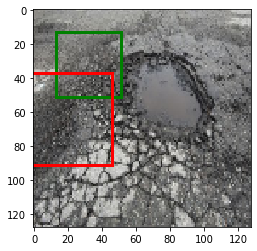

In [15]:
box1 = np.array([.10, .10, .30, .30])


fig = plt.figure()
plt.imshow(X[4])
a1 = plt.gca()
rect = pat.Rectangle((box1[0]*128.0,box1[1]*128.0),box1[2]*128.0,box1[3]*128.0, linewidth = 3, edgecolor='g', facecolor='none')
a1.add_patch(rect)

rotatedBox = rotate_coords(box1, 45) * 128.0
rect = pat.Rectangle((rotatedBox[0],rotatedBox[1]),rotatedBox[2],rotatedBox[3], linewidth = 3, edgecolor='r', facecolor='none')
a1.add_patch(rect)

In [16]:
max_brightness_factor = 0.2
max_rotation_angle = 45

class PotholeBatchGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, 
                x_set,
                y_set,
                batch_size,
                image_dims=newSize,
                 shuffle=True,
                 num_channels=3,
                 num_outputs=4,
                 is_train=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dims = image_dims
        self.shuffle=shuffle
        self.num_channels = num_channels
        self.num_outputs = num_outputs
        self.num_images = self.x.shape[0]
        self.indexes = np.arange(self.num_images)
        self.is_train = is_train
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(self.num_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.num_images)
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dims, self.num_channels))
        y = np.empty((self.batch_size, self.num_outputs))
        
        for i in range(self.batch_size):
            y[i,:] = self.y[batch_indexes[i],:]
            
            flip_flag = np.random.randint(2)
            if flip_flag ==1 and self.is_train:
                x[i, :, :, :] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                y[i, 0] = 1-y[i, 0] - y[i, 2]
            else:
                x[i, :, :, :] = self.x[batch_indexes[i],:,:,:]
                
            
            
            
            if self.is_train:
                brightness_mult = np.random.random()*max_brightness_factor*2 - max_brightness_factor + 1
                x[i,:,:,:] = brightness_mult * x[i,:,:,:]
                
        if self.is_train:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
            
            for i in range(self.batch_size):
                y[i, :] = rotate_coords(y[i, :], angle)
            x = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
        else:
            angle = 0
        
        
        
        return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


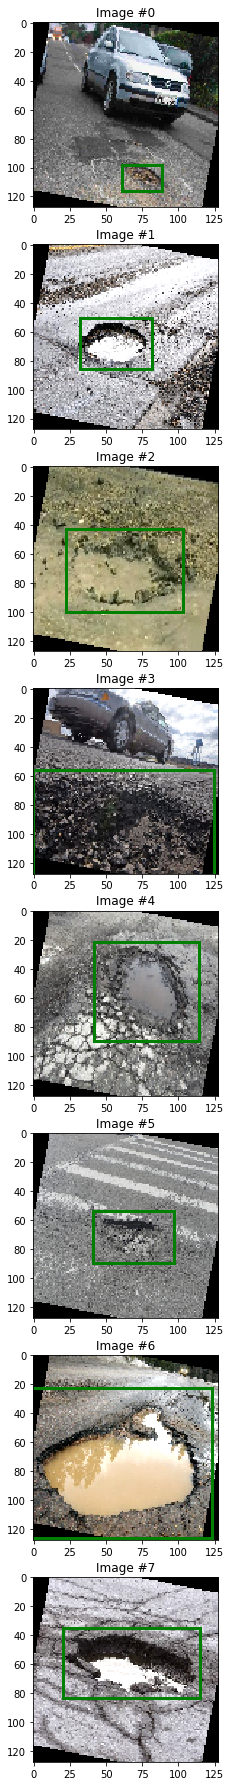

In [17]:
# looking at batch generator

batch_size = 16
num_show=8

gen = PotholeBatchGenerator(X, Y, batch_size, shuffle=False, is_train=True)

bx, by = gen.__getitem__(0)
# print(bx.shape)

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    
    [x,y,w,h] = by[i,:]
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]
    
    
    a1 = fig.add_subplot(num_show, 3, i*3+1)
    img1 = a1.imshow(bx[i,:,:,:])
    a1.set_title("Image #{}".format(i))
    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
#     print((x,y,w,h))
    a1.add_patch(rect)


### Model design

In [18]:
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(newSize[0],newSize[1], 3), activation='relu'))
# model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (2,2), activation='relu'))
# model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (2,2), activation='relu'))
# model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, (2,2), activation='relu'))
# model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(256, (2,2), activation='relu'))
# model.add(Conv2D(256, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('linear'))



In [19]:
model.compile(optimizer= 'adam', loss='mean_absolute_error')

In [20]:
train_gen = PotholeBatchGenerator(X_train, Y_train, 8)
test_gen = PotholeBatchGenerator(X_test, Y_test, 8, is_train=False)

In [21]:
history = model.fit_generator(train_gen, validation_data=test_gen, epochs=100)

Epoch 1/100
62/62 [==============================] - 8s 133ms/step - loss: 0.1318 - val_loss: 0.1010
Epoch 2/100
62/62 [==============================] - 4s 63ms/step - loss: 0.1125 - val_loss: 0.0882
Epoch 3/100
62/62 [==============================] - 5s 76ms/step - loss: 0.1001 - val_loss: 0.0929
Epoch 4/100
62/62 [==============================] - 5s 83ms/step - loss: 0.0987 - val_loss: 0.0782
Epoch 5/100
62/62 [==============================] - 5s 81ms/step - loss: 0.0917 - val_loss: 0.0780
Epoch 6/100
62/62 [==============================] - 6s 93ms/step - loss: 0.0863 - val_loss: 0.0821
Epoch 7/100
62/62 [==============================] - 6s 94ms/step - loss: 0.0906 - val_loss: 0.0870
Epoch 8/100
62/62 [==============================] - 6s 93ms/step - loss: 0.0850 - val_loss: 0.0711
Epoch 9/100
62/62 [==============================] - 5s 86ms/step - loss: 0.0808 - val_loss: 0.0732
Epoch 10/100
62/62 [==============================] - 5s 83ms/step - loss: 0.0814 - val_loss: 0.065

62/62 [==============================] - 5s 85ms/step - loss: 0.0473 - val_loss: 0.0544
Epoch 83/100
62/62 [==============================] - 5s 84ms/step - loss: 0.0530 - val_loss: 0.0544
Epoch 84/100
62/62 [==============================] - 5s 85ms/step - loss: 0.0491 - val_loss: 0.0562
Epoch 85/100
62/62 [==============================] - 5s 78ms/step - loss: 0.0527 - val_loss: 0.0498
Epoch 86/100
62/62 [==============================] - 5s 81ms/step - loss: 0.0524 - val_loss: 0.0580
Epoch 87/100
62/62 [==============================] - 6s 94ms/step - loss: 0.0499 - val_loss: 0.0493
Epoch 88/100
62/62 [==============================] - 6s 91ms/step - loss: 0.0471 - val_loss: 0.0546
Epoch 89/100
62/62 [==============================] - 5s 84ms/step - loss: 0.0486 - val_loss: 0.0503
Epoch 90/100
62/62 [==============================] - 6s 93ms/step - loss: 0.0513 - val_loss: 0.0494
Epoch 91/100
62/62 [==============================] - 6s 90ms/step - loss: 0.0480 - val_loss: 0.0502
Epo

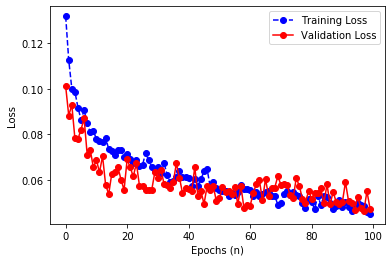

In [22]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'] ,'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

(41.4, 37.0721435546875)
(38.51851851851852, 36.558258056640625)
(36.333333333333336, 37.56774139404297)
(27.733333333333334, 29.342615127563477)


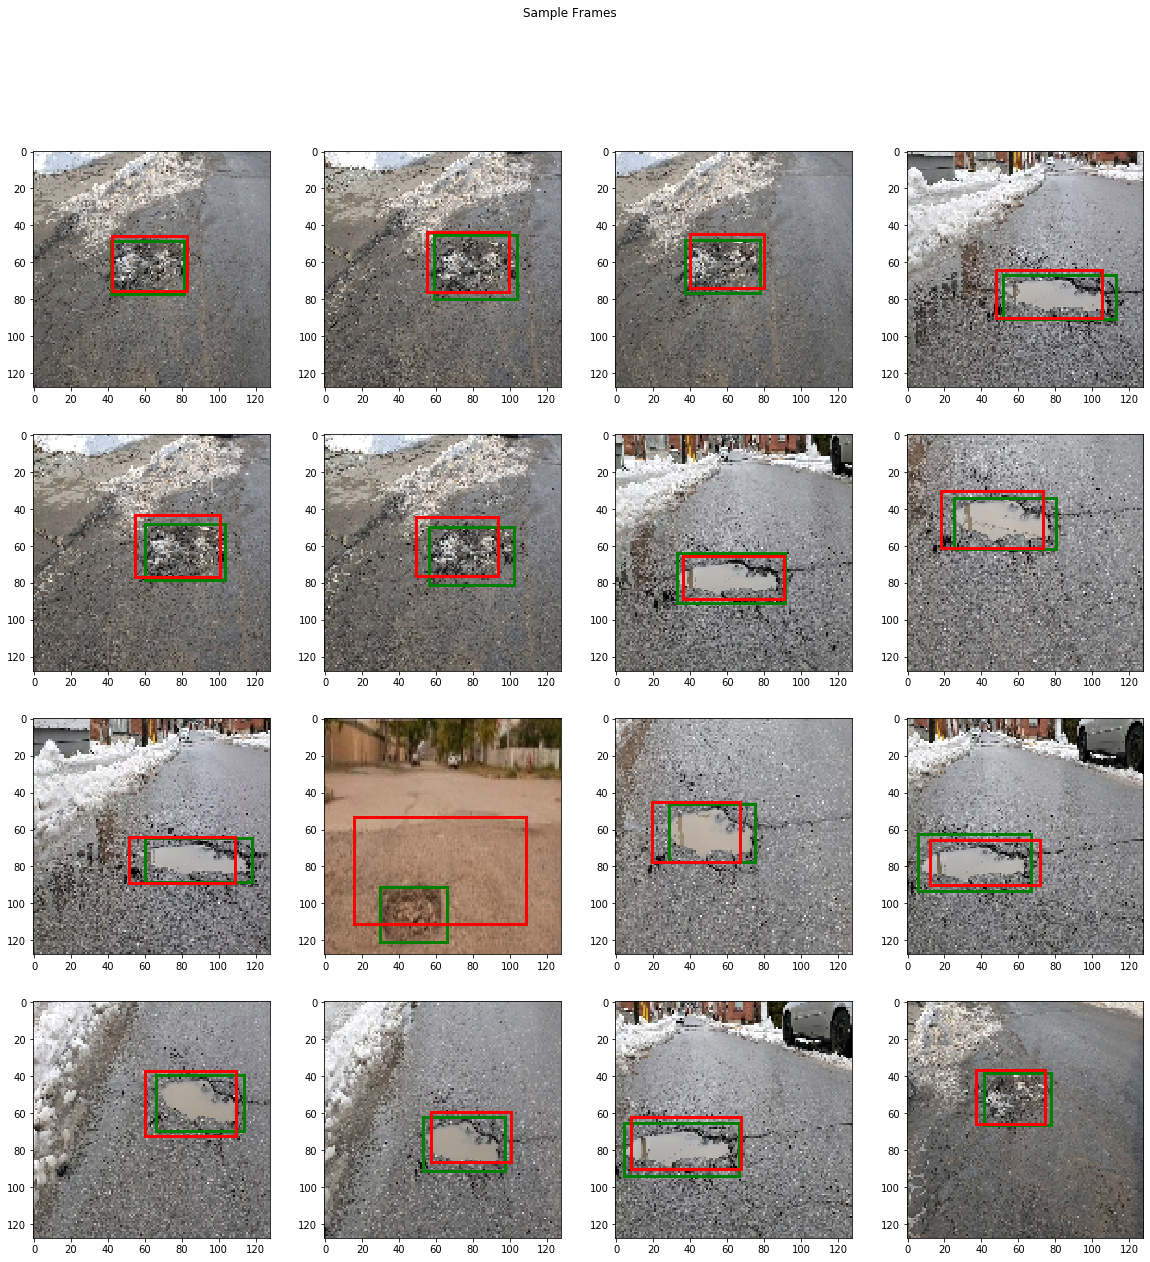

In [23]:
shift = 4
sampleNum = 16
fig, axs = plt.subplots(sampleNum//4, 4, figsize=(20,20))
fig.suptitle("Sample Frames")

for imgNum in range(sampleNum):
    plt.imshow(X_test[imgNum])
    axs[imgNum//4][imgNum%4].imshow(X_test[20+imgNum + shift])
    
    
    [x,y,w,h] = Y_test[20+imgNum + shift]
    [[x1,y1,w1,h1]] = model.predict(np.expand_dims(X_test[20+imgNum + shift], axis=0))
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]

    x1= x1*newSize[0]
    y1= y1*newSize[1]
    w1= w1*newSize[0]
    h1= h1*newSize[1]

    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect)
    rect1 = pat.Rectangle((x1,y1),w1,h1, linewidth = 3, edgecolor='r', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect1)
print((x,x1))
print((y,y1))
print((w,w1))
print((h,h1))

In [25]:
from datetime import datetime
timeStamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_file_path = os.path.join(absFolder, "model_" + timeStamp + ".h5")
model.save(model_file_path)
print("Model saved to {}".format(model_file_path))

Model saved to C:\Users\jaker\Documents\Robo-Traverse\Notebooks\model_2020-01-30_19-11-26.h5
